In [17]:
import pandas as pd
import numpy as np

df = pd.read_csv("preprocessed_df.csv", encoding = "ISO-8859-1")
df.head()

,article
0,"['musician', 'tackle', 'u', 'red', 'tape', 'mu..."
1,"['u2s', 'desire', 'number', 'one', 'u2', 'thre..."
2,"['rocker', 'doherty', 'onstage', 'fight', 'roc..."
3,"['snicket', 'top', 'u', 'box', 'office', 'char..."
4,"['ocean', 'twelve', 'raid', 'box', 'office', '..."


In [18]:
# Charger les données en utilisant pandas
df = pd.read_csv("preprocessed_df.csv", encoding = "ISO-8859-1")

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


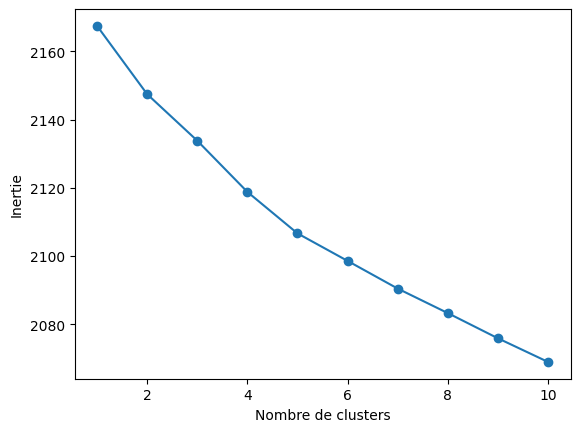

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Créer un vecteur de fonctionnalités
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['article'])

# Calculer l'inertie pour différents nombres de clusters
inertias = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Tracer l'inertie en fonction du nombre de clusters
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.show()

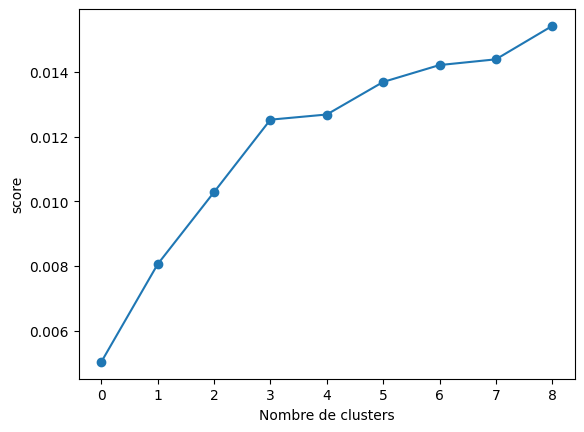

Le meilleur nombre de clusters est : 10


In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['article'])

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    score = silhouette_score(X, kmeans.labels_)
    scores.append(score)

# Tracer l'inertie en fonction du nombre de clusters
plt.plot(scores, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("score")
plt.show()

best_k = np.argmax(scores) + 2
print("Le meilleur nombre de clusters est :", best_k)

In [21]:
k_best = 5

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

df = pd.read_csv("preprocessed_df.csv", encoding = "ISO-8859-1")

# Créer un pipeline de traitement des données
vectorizer = TfidfVectorizer()
kmeans = KMeans(n_clusters=k_best)
pipeline = Pipeline([("vectorizer", vectorizer), ("kmeans", kmeans)])

# Entraîner le modèle
X = df['article']
pipeline.fit(X)
df["cluster"] = kmeans.labels_

# Extraire les centres des clusters
cluster_centers = kmeans.cluster_centers_

# Déterminer le vocabulaire associé à chaque cluster
vocabulary = vectorizer.vocabulary_

# Fonction pour trouver les mots les plus pertinents pour chaque cluster
def find_top_words(cluster_index, n_words=10):
    cluster = cluster_centers[cluster_index]
    sorted_indexes = np.argsort(-cluster)
    words = [word for index in sorted_indexes[:n_words] for word, weight in vocabulary.items() if weight == index]
    return words

# Afficher les mots les plus pertinents pour chaque cluster
for i in range(kmeans.n_clusters):
    print("Cluster", i + 1)
    print("Top words:", find_top_words(i))
    print("\n")

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 1
Top words: ['film', 'award', 'best', 'star', 'band', 'music', 'actor', 'oscar', 'album', 'chart']


Cluster 2
Top words: ['said', 'year', 'mr', 'company', 'firm', 'bank', 'government', 'growth', 'economy', 'market']


Cluster 3
Top words: ['mobile', 'phone', 'people', 'technology', 'said', 'game', 'user', 'service', 'computer', 'software']


Cluster 4
Top words: ['mr', 'labour', 'election', 'party', 'blair', 'tory', 'said', 'brown', 'tax', 'would']


Cluster 5
Top words: ['game', 'england', 'player', 'win', 'said', 'match', 'cup', 'club', 'champion', 'team']




In [23]:
import spacy
from scipy import spatial

nlp = spacy.load("en_core_web_md")

# Define the list of topics
topics = ["Politics", "Economy", "Informatics", "Sport", "Art", "Music", "Cinema", "History", "Health", "Security", "Media", "Entertainment", "Gastronomy", "Animals", "Fashion"]


def topicFromWords(words):

    # Create embeddings for the words
    word_embeddings = [nlp(word).vector for word in words]

    # Create embeddings for the topics
    topic_embeddings = [nlp(topic).vector for topic in topics]

    # Find the most similar topic
    similarities = [spatial.distance.cosine(sum(word_embeddings)/len(word_embeddings), topic_embedding) for topic_embedding in topic_embeddings]
    most_similar_topic = topics[similarities.index(min(similarities))]

    # Print the most similar topic
    return most_similar_topic

In [24]:
clusters_topic = {}
for i in range(k_best):
    clusters_topic[i] = topicFromWords(find_top_words(i))

df["topic"] = df["cluster"].apply(lambda x: clusters_topic[x])

In [25]:
df.to_csv("clusterized_df.csv", index=False)